In [1]:
import sys
sys.path.append('models')

# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/MyDrive/Dissertation/models')
# sys.path.append('/content/drive/MyDrive/Dissertation')

In [2]:
# !pip install dask_ml
# !pip install scikeras
# import nltk
# nltk.download('stopwords')
# import nltk
# nltk.download('punkt')

In [3]:
# importing libraries
import joblib
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from collections import defaultdict
import matplotlib.pyplot as plt

from logstic_regression import Logistic_Regression
from XGBoost import XGBoost
from naive_bayes import Naive_Bayes
from rnn import RNN
from cnn import CNN
# from models.bert import BERT
from bilstm import BiLSTM

# Load the TextPreprocessor class (assumed to be defined already)
from textpreprocessor import TextPreprocessor
from evaluation_visualization import Evaluation_Visualization

import warnings
warnings.filterwarnings("ignore")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-10-27 20:16:42.031496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 20:16:42.040052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 20:16:42.042541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 20:16:42.049070: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 20:16:42.712119: W tensorflow/compiler/tf2

Num GPUs Available:  1


I0000 00:00:1730056604.624798 1444252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730056604.631825 1444252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730056604.631857 1444252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
NUM_SAMPLE = 10000
TEST_RATIO=0.2
BATCH_SIZE=512
EPOCHS = 10
MAX_WORD_COUNT = 5000
MAX_LENGTH = 222
OUTPUT_RESULT_DIR = "output/result"
OUTPUT_MODELS_DIR = "output/models"
USE_TEST_DATA = True
INPUT_DIR = f"input/sample_{NUM_SAMPLE}"

os.makedirs(OUTPUT_RESULT_DIR, exist_ok=True)
os.makedirs(OUTPUT_MODELS_DIR, exist_ok=True)

eval_and_visual = Evaluation_Visualization(out_result_dir= OUTPUT_RESULT_DIR, out_models_dir=OUTPUT_MODELS_DIR)

00. Text Pre-Processing

In [5]:
# Initialize the Text Preprocessor
processor = TextPreprocessor(MAX_WORD_COUNT, MAX_LENGTH)

if USE_TEST_DATA:
    # Load data
    df_train = pd.read_csv(os.path.join(INPUT_DIR, 'train_cleaned.csv'))
    df_test = pd.read_csv(os.path.join(INPUT_DIR, 'test_cleaned.csv'))
    # df_test = processor.load_data()
    X_train = df_train['review']
    X_test = df_test['review']
    y_train = df_train['polarity']
    y_test = df_test['polarity']
    # X_train_seq_padded = pickle.load(os.path.join(INPUT_DIR, 'X_train_pad.pkl'))
    # X_test_seq_padded = pickle.load(os.path.join(INPUT_DIR, 'X_test_pad.pkl'))
else:
    # Load data
    df_train, df_test = processor.parallel_load_data()

    df_train_step1 = processor.remove_stopwords(df_train.copy())
    df_test_step1 = processor.remove_stopwords(df_test.copy())

    print('----------TRAIN DATA----------')
    df_train_step2 = processor.filter_by_length_of_sentence(df_train_step1.copy(),50)
    print('----------TEST DATA----------')
    df_test_step2 = processor.filter_by_length_of_sentence(df_test_step1.copy(),50)

    df_train_step3 = processor.sampling_data(df_train_step2, NUM_SAMPLE)
    df_test_step3 = processor.sampling_data(df_test_step2, int(NUM_SAMPLE*TEST_RATIO))

    # Preprocess data
    df_train_step3 = processor.map_polarity(df_train_step3.copy())
    df_test_step3 = processor.map_polarity(df_test_step3.copy())

    # Split data
    X_train, y_train = processor.split_data(df_train_step3)
    X_test, y_test = processor.split_data(df_test_step3)
    
    os.makedirs(INPUT_DIR, exist_ok=True)
    # Save data
    df_train_step3.to_csv(os.path.join(INPUT_DIR, 'train_cleaned.csv'), index=False)
    df_test_step3.to_csv(os.path.join(INPUT_DIR, 'test_cleaned.csv'), index=False)

X_train_tfidf, X_test_tfidf = processor.vectorize_text(X_train, X_test)
X_train_pad, X_test_pad = processor.tokenization_and_padding(X_train, X_test)

MAX_LENGTH = processor.max_length

07. Bidirectional Long Short-Term Memory (BiLSTM)

In [6]:
# 1. Train Model
bilstm = BiLSTM(processor.tokenizer, EPOCHS, BATCH_SIZE, verbose=1)
bilstm.train_model(X_train_pad, y_train, X_test_pad,y_test)

# 2. Random SearchCV
bilstm.random_search(X_train_pad, y_train, X_test_pad,y_test, n_iter=2, cv=3, random_state=42, n_jobs=1, patience = 2)


I0000 00:00:1730056604.928058 1444252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730056604.928104 1444252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730056604.928119 1444252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730056605.029267 1444252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730056605.029315 1444252 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-27

Epoch 1/10


2024-10-27 20:16:46.490732: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5435 - loss: 0.6854 - val_accuracy: 0.6790 - val_loss: 0.6148
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7861 - loss: 0.4992 - val_accuracy: 0.8270 - val_loss: 0.3938
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8813 - loss: 0.2912 - val_accuracy: 0.8265 - val_loss: 0.4030
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9139 - loss: 0.2232 - val_accuracy: 0.8280 - val_loss: 0.4126
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9372 - loss: 0.1716 - val_accuracy: 0.8195 - val_loss: 0.4630
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5128 - loss: 0.6910 - val_accuracy: 0.5815 - val_loss: 0.6749
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7026 - loss: 0.6615 - val_accuracy: 0.7465 - val_loss: 0.5655
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 

In [7]:
_, best_params = eval_and_visual.compare_models_accuracy_and_get_best_params({'Original': bilstm.model,
                                                              'RandomizedSearchCV': bilstm.random_search_cv}, X_test_pad, y_test)

# {'dropout': 0.01, 'recurrent_dropout': 0.01, 'optimizer': 'adam', 'output_dim': 1, 'lstm_units': 100, 'embedding_dim': 64, 'learning_rate': 0.1}

if 'build_fn' in best_params:
    best_params = best_params['build_fn'].keywords
else:
    print("'build_fn' key does not exist in best_params.")
    
print(f'best parameters: {best_params}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Original Accuracy: 82.69999999999999
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
RandomizedSearchCV Accuracy: 82.75
Best Model: RandomizedSearchCV with Accuracy: 82.75
Best Parameters: {'recurrent_dropout': 0.01, 'output_dim': 1, 'optimizer': 'rmsprop', 'lstm_units': 50, 'epochs': 10, 'embedding_dim': 64, 'dropout': 0.4, 'batch_size': 512}
'build_fn' key does not exist in best_params.
best parameters: {'recurrent_dropout': 0.01, 'output_dim': 1, 'optimizer': 'rmsprop', 'lstm_units': 50, 'epochs': 10, 'embedding_dim': 64, 'dropout': 0.4, 'batch_size': 512}


In [8]:
# 3. Grid SearchCV
bilstm.grid_search(X_train_pad, y_train, X_test_pad, y_test, best_params= best_params, cv=3, n_jobs=1, patience=2)

_, best_params = eval_and_visual.compare_models_accuracy_and_get_best_params({'RandomizedSearchCV': bilstm.random_search_cv,
                                                              'GridSearchCV': bilstm.grid_search_cv}, X_test_pad, y_test)

# 4. Train Best Model
bilstm.train_best_model(X_train_pad, y_train, X_test_pad, y_test, best_params=best_params, patience=2)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5258 - loss: 0.6911 - val_accuracy: 0.5675 - val_loss: 0.6732
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6321 - loss: 0.6540 - val_accuracy: 0.7225 - val_loss: 0.5747
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8031 - loss: 0.4986 - val_accuracy: 0.8050 - val_loss: 0.4191
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8626 - loss: 0.3222 - val_accuracy: 0.8205 - val_loss: 0.4069
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9032 - loss: 0.2497 - val_accuracy: 0.8250 - val_loss: 0.4118
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9297 - loss: 0.1799 - val_accuracy: 0.8235 - val_loss: 0.4635
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5223 - loss: 0.6902 - val_accuracy: 0.5570 - val_loss: 0.6665
Epoch 2/10
14/14 ━━

OSError: Cannot save file into a non-existent directory: 'Output/result'

In [10]:

# 5. Evaluate and Save Models
eval_and_visual.evaluate_model_class(bilstm,X_test_pad, y_test)

bilstm.save_model_and_params(
    os.path.join(OUTPUT_MODELS_DIR, 'bilstm_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'bilstm_best_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'bilstm_best_params.pkl')
    )

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step
Model saved to Output/models/bilstm_model.pkl
Best model saved to Output/models/bilstm_best_model.pkl
Best parameters saved to Output/models/bilstm_best_params.pkl


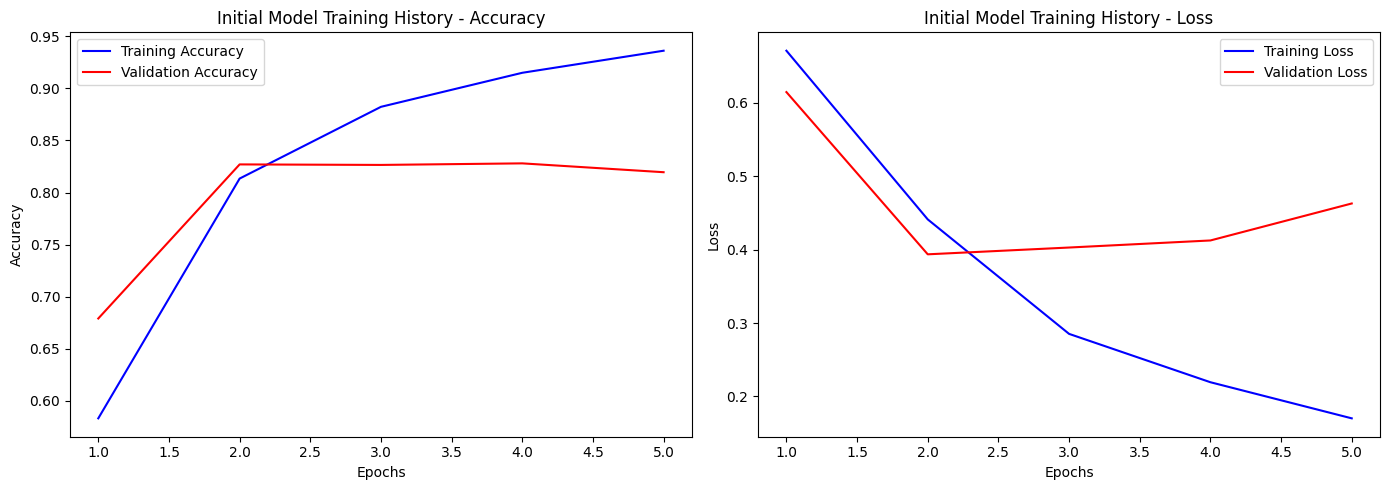

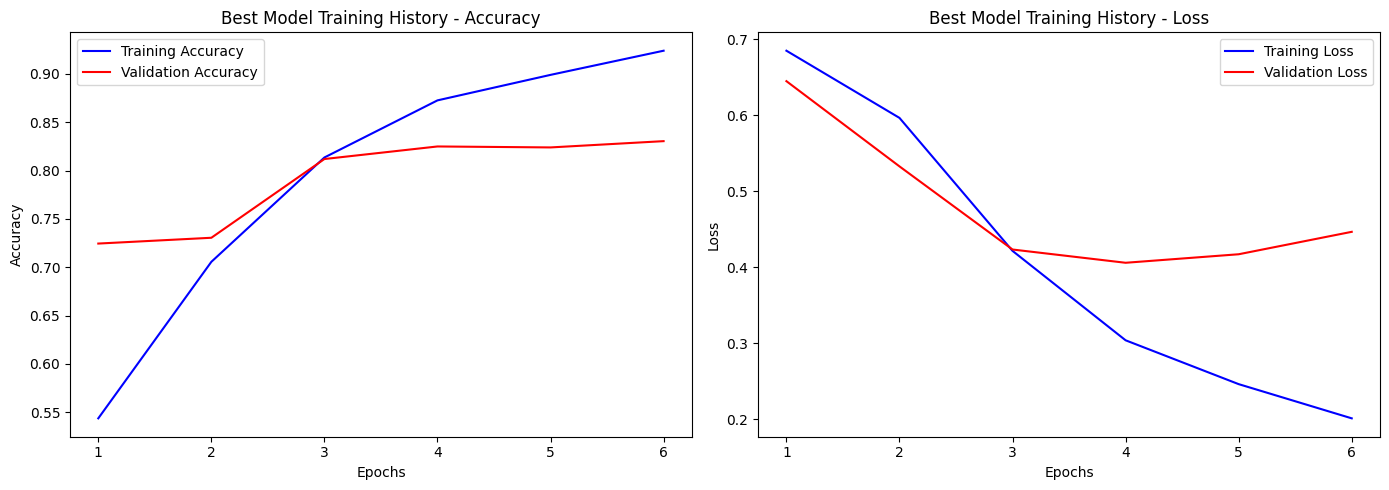

In [11]:
# Plot for hist
eval_and_visual.plot_training_history_from_dict(bilstm.model.history_, title="Initial Model Training History")

# Plot the training history from defaultdict data
eval_and_visual.plot_training_history_from_dict(bilstm.best_model.history_, title="Best Model Training History")

In [13]:
eval_and_visual.df_results

,Model,Training-Time,Accuracy,Precision (Class 0),Precision (Class 1),Recall (Class 0),Recall (Class 1),F1-Score (Class 0),F1-Score (Class 1)
0,BiLSTM,5.730249,82.70,0.811859,0.838825,0.797312,0.850949,0.804520,0.844843
1,BiLSTM_random_search,412.451746,82.75,0.807865,0.843243,0.805151,0.845528,0.806506,0.844384
2,BiLSTM_grid_search,2636.996431,83.10,0.842170,0.823381,0.764838,0.884372,0.801643,0.852787
3,BiLSTM_best,100.330228,82.50,0.798680,0.846929,0.812990,0.834688,0.805771,0.840764


In [14]:
bilstm.model.get_params()['build_fn'].keywords

{'dropout': 0.01,
 'recurrent_dropout': 0.01,
 'optimizer': 'adam',
 'output_dim': 1,
 'lstm_units': 100,
 'embedding_dim': 64,
 'learning_rate': 0.1}

In [15]:
bilstm.random_search_cv.best_params_

{'recurrent_dropout': 0.01,
 'output_dim': 1,
 'optimizer': 'rmsprop',
 'lstm_units': 50,
 'epochs': 10,
 'embedding_dim': 64,
 'dropout': 0.4,
 'batch_size': 512}

In [16]:
bilstm.grid_search_cv.best_params_

{'batch_size': 512,
 'dropout': 0.36000000000000004,
 'embedding_dim': 64,
 'epochs': 10,
 'lstm_units': 50,
 'optimizer': 'rmsprop',
 'recurrent_dropout': 0.009000000000000001}

In [19]:
bilstm.best_model.get_params()

{'model': None,
 'build_fn': functools.partial(<bound method BiLSTM.__create_bilstm_model of <bilstm.BiLSTM object at 0x7fd8455a7fd0>>, dropout=0, recurrent_dropout=0, optimizer='adam', output_dim=1, lstm_units=100, embedding_dim=64, learning_rate=0.1),
 'warm_start': False,
 'random_state': None,
 'optimizer': 'rmsprop',
 'loss': None,
 'metrics': None,
 'batch_size': None,
 'validation_batch_size': None,
 'verbose': 1,
 'callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping at 0x7fd840022bb0>],
 'validation_split': 0.0,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 1,
 'dropout': 0.36000000000000004,
 'recurrent_dropout': 0.009000000000000001,
 'output_dim': 1,
 'lstm_units': 50,
 'embedding_dim': 64,
 'class_weight': None}